In [1]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle, json, matplotlib, sys, time
from multiprocessing import Pool, Manager
from collections import OrderedDict
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd
import seaborn as sns; from sqlalchemy import create_engine
from IPython import display
%matplotlib inline

# When is a user _Experienced_?
This is a difficult question in that we cannot simply take above the mean / below the mean because of the problematic distributions within the database.

 - We can look at users who map more buildings than roads? 
 - We can look at users with more than half of their edits to buildings?

In [2]:
study_tiles = json.loads(open('../study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

Found 9 tiles.


In [3]:
years = [2005+i for i in range(12)]
years

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

In [4]:
# Create connections for panda queries
pd_engines = []
pd_connections = []
for idx, year in enumerate(years):
    pd_engines.append( create_engine("postgresql://anderstj@127.0.0.1:5432/world-{0}".format(year)) )
    pd_connections.append(pd_engines[idx].connect())

def reset(pd_connections):
    new_cons = []
    for idx, con in enumerate(pd_connections):
        con.close()
        new_cons.append(pd_engines[idx].connect())
    return new_cons

# pd_connections = reset(pd_connections)

In [5]:
def get_all_users_who_edited_tile(tile):
    users_on_tile = []
    for idx, year in enumerate(years):
        print(year, end=" . ")
        query_string = """SELECT distinct(uid) FROM per_tile WHERE quadkey = '{0}'""".format(tile['quad'])
        year_df = pd.read_sql_query(query_string,con=pd_connections[idx])
        users_on_tile = np.append(users_on_tile,year_df.uid.values)
    return np.unique(users_on_tile)

def annual_worker_function(args):
    """
    Input: List of users and a year of choice
    Returns: Dictionary, keyed by UID of all a user's edits for given year
    """
    (user_list, year_idx, q) = args
    dict_to_return = {}

    #Query for 50 users at a time
    for sub_list in [user_list[i:i + 50] for i in range(0, len(user_list), 50)]:
    
        query_string = """SELECT per_tile.quadkey,
                                 per_tile.year,
                                 per_tile.uid,
                                 per_tile.buildings,
                                 per_tile.road_km,
                                 per_tile.amenities,
                                 per_tile.edits,
                                 array_length(per_tile.active_days,1) AS "num_days",
                                 user_stats.uid AS "user_stats_uid",
                                 user_stats.name AS "user_name",
                                 user_stats.year AS "total_year",
                                 user_stats.buildings AS "total_buildings",
                                 user_stats.road_km AS "total_road_km",
                                 user_stats.amenities AS "total_amenities",
                                 user_stats.edits AS "total_edits",
                                 array_length(user_stats.active_days,1) AS "total_active_days"
                          FROM per_tile, user_stats 
                          WHERE per_tile.uid = user_stats.uid AND 
                                per_tile.uid = ANY(ARRAY[%s])"""%(", ".join([str(i) for i in sub_list]))
        df = pd.read_sql_query(query_string, con=pd_connections[year_idx])
        
#         with open('tmp.log','w') as oFile:
#             oFile.write(df.to_csv())

        for uid in df['uid'].unique():
            dict_to_return[uid] = df[:][df.uid == uid]
            q.put(1)
    return dict_to_return

def build_user_distributions(uids):
    """
        Given a list of user ids, spin up 12 processes (1 per year) to get back dictionaries, keyed by UID
            of all a user's tiles for that year; then combine all of the years.
        
        Returns: A dictionary: { UID : DataFrame of all a user's edits (across all years) }
    """
    m = Manager()
    q = m.Queue()
    p = Pool(12)
    args = [ (uids, year_idx, q) for year_idx in range(12)]
    
    max_val = round(len(uids)*len(args)*0.4)

    result = p.map_async(annual_worker_function, args)
    
    while True:
        if result.ready():
            break
        else:
            size = q.qsize()
            sys.stderr.write("\r "+str(size)+ "/ ~ " + str(max_val))
            time.sleep(1)
    
    aggregated = {}
    
    for year_data in result.get():
        for uid, data in year_data.items():
            if uid in aggregated:
                aggregated[uid]['df'] = pd.concat([aggregated[uid]['df'], data], ignore_index=True)
            else:
                #This is the first we see this user
                aggregated[uid] = {'df':data}
    p.close()
    return aggregated

### With each user's dataframe, compute user focus stats

In [6]:
def calculate_user_focus(args):
    """
    
    """
    df, q = args
    agged_quad = df.groupby('quadkey').aggregate({'buildings':sum,
                                                 'road_km'  :sum,
                                                 'edits'    :sum,
                                                 'amenities':sum,
                                                 'num_days' :sum})
    
    agged_quad['percent_user_road_km']   = agged_quad.road_km   / agged_quad.road_km.sum()*100
    agged_quad['percent_user_buildings'] = agged_quad.buildings / agged_quad.buildings.sum()*100
    agged_quad['percent_user_amenities'] = agged_quad.amenities / agged_quad.amenities.sum()*100
    agged_quad['percent_user_edits']     = agged_quad.edits     / agged_quad.edits.sum()*100
    

    annual_stats = pd.DataFrame()
    for year in df.total_year.unique():
        this_year = df[['uid','user_name','year','total_buildings','total_road_km','total_amenities','total_edits','total_active_days']].query('year=={0}'.format(year)).head(1)
        annual_stats = pd.concat( [annual_stats, this_year], ignore_index=True)
    
    if(q):
        q.put(1)
    return (agged_quad, annual_stats)

def process_dictionary_of_users(user_dict):
    """
    
    """
    sorted_users = sorted(list(user_dict.keys()))
    
    m = Manager()
    q = m.Queue()
    p = Pool(24)
    
    args = [ (user_dict[uid]['df'], q) for uid in sorted_users]
    result = p.map_async(calculate_user_focus, args)
    
    while True:
        if result.ready():
            break
        else:
            sys.stderr.write("\r "+str(q.qsize())+ "/" + str(len(sorted_users)))
            time.sleep(0.5)

    res = result.get()
    for idx, user in enumerate(sorted_users):
        user_dict[user]['tiles'] = res[idx][0]
        user_dict[user]['annual'] = res[idx][1]
        
    p.close()

In [7]:
def build_all_stats_for_tile(current_tile):
    """
    
    """
    current_tile_df = pd.DataFrame()
    for u,data in current_tile['users'].items():
        data['tiles']['uid'] = u
        data['tiles']['total_editing_days_ever'] = data['annual'].total_active_days.sum()
        data['tiles']['total_buildings_ever'] = data['annual'].total_buildings.sum()
        data['tiles']['total_road_km_ever'] = data['annual'].total_road_km.sum()
        data['tiles']['total_amenities_ever'] = data['annual'].total_amenities.sum()
        data['tiles']['total_edits_ever'] = data['annual'].total_edits.sum()
        current_tile_df = pd.concat([current_tile_df, pd.DataFrame(data['tiles'].query("quadkey=='{0}'".format(current_tile['quad'])))],ignore_index=True)

    current_tile_df['percent_tile_road_km']   = current_tile_df.road_km   / current_tile_df.road_km.sum()*100
    current_tile_df['percent_tile_buildings'] = current_tile_df.buildings / current_tile_df.buildings.sum()*100
    current_tile_df['percent_tile_amenities'] = current_tile_df.amenities / current_tile_df.amenities.sum()*100
    current_tile_df['percent_tile_edits']     = current_tile_df.edits     / current_tile_df.edits.sum()*100
    
    return current_tile_df

# Study Tiles: Load data for a specific study tile

In [8]:
for idx, tile in enumerate(study_tiles):
    print(idx, tile['name'])

0 Port Au Prince, Haiti
1 Trisuli Bazar, Nepal
2 Tacloban
3 Kenema, Sierra Leone
4 Monrovia, Liberia
5 Kathmandu, Nepal
6 Heidelberg, Germany
7 London
8 Manhattan, NY


## 1. Get the `user_list`

In [9]:
"""
    First: Set the index for the study tile you want.
"""
study_tile_idx = 4

In [10]:
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

In [11]:
print("Found: {0} users".format(len(study_tiles[study_tile_idx]['user_list'])))

Found: 201 users


## 2. Build the User Distributions
If this doesn't run, run the cell 2 above again)

In [12]:
study_tiles[study_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['user_list'])

 788/ ~ 965

### Check these results

In [13]:
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,031311303031,2007,1611,0,0.00000,1,29,1,1611,Harry Wood,2007,12,188.38,275,7583,97
1,031311303030,2007,1611,0,0.00000,0,1,1,1611,Harry Wood,2007,12,188.38,275,7583,97
2,031311303032,2007,1611,0,4.96562,0,137,2,1611,Harry Wood,2007,12,188.38,275,7583,97
3,031311303122,2007,1611,0,6.17258,0,107,1,1611,Harry Wood,2007,12,188.38,275,7583,97
4,031311303033,2007,1611,2,6.91752,9,299,6,1611,Harry Wood,2007,12,188.38,275,7583,97


## 3. Get tile focus for each user

In [14]:
process_dictionary_of_users(study_tiles[study_tile_idx]['users'])

 201/201

### Inspect these

In [15]:
# So what's saved from this?
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['tiles'].head())
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['annual'].head())

,buildings,road_km,edits,amenities,num_days,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
002321010132,0,0.0,2,0,1,0.0,0.0,0.0,0.00350
002321010133,0,0.0,1,0,1,0.0,0.0,0.0,0.00175
002321010301,0,0.0,1,0,1,0.0,0.0,0.0,0.00175
002321010302,0,0.0,2,0,1,0.0,0.0,0.0,0.00350
002321010303,0,0.0,2,0,1,0.0,0.0,0.0,0.00350


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,1611,Harry Wood,2007,12,188.380,275,7583,97
1,1611,Harry Wood,2008,55,519.104,646,7239,118
2,1611,Harry Wood,2009,246,2566.280,728,7801,146
3,1611,Harry Wood,2010,333,494.419,345,3098,128
4,1611,Harry Wood,2011,2396,1022.150,692,8050,175


## 4. Who is mapping what: Build Current Tile DF

In [16]:
current_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx])

In [17]:
current_tile_df.head()

,buildings,road_km,edits,amenities,num_days,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits,uid,total_editing_days_ever,total_buildings_ever,total_road_km_ever,total_amenities_ever,total_edits_ever,percent_tile_road_km,percent_tile_buildings,percent_tile_amenities,percent_tile_edits
0,11,0.000000,16,4,2,0.000000,0.033177,0.849257,0.040699,1443840,276,33155,2078.421800,471,39313,0.000000,0.057033,3.030303,0.069765
1,0,0.000000,2,0,1,0.000000,0.000000,0.000000,0.005760,343553,616,1305,45503.397000,622,34725,0.000000,0.000000,0.000000,0.008721
2,339,3.026860,363,0,3,0.002172,5.566502,0.000000,0.244527,104962,1371,6090,139356.330000,2111,148450,0.822208,1.757661,0.000000,1.582803
3,3,0.628062,13,6,1,100.000000,100.000000,100.000000,100.000000,3170819,1,3,0.628062,6,13,0.170605,0.015555,4.545455,0.056684
4,38,0.485150,40,0,2,0.334049,6.540448,0.000000,4.366812,1897988,37,581,145.233400,6,916,0.131785,0.197024,0.000000,0.174414


Processed Study tiles now have the following attributes: 

- **name**: Name of Region
- **user_list**: List of UIDs of users who have edited on this tile
- **users**: Dictionary, keyed by UID
  - `uid`:
    - **df**: Full dataframe of all edits on all tiles by this user
    - **tiles**: DataFrame of unique tiles, summed over all years
    - **annual**: DataFrame of Editing Aggregates over all tiles, per year

# Begin Analysis

In [18]:
print("Current Study Tile: {0}".format(study_tiles[study_tile_idx]['name']))
print("\tUsers: {0}".format(len(study_tiles[study_tile_idx]['user_list'])))
print("Current_tile_df size: {0} (Should match the user count)".format(len(current_tile_df)))

Current Study Tile: Monrovia, Liberia
	Users: 201
Current_tile_df size: 201 (Should match the user count)


## Percentage of a User's edits (of all time) that occur on this tile: 

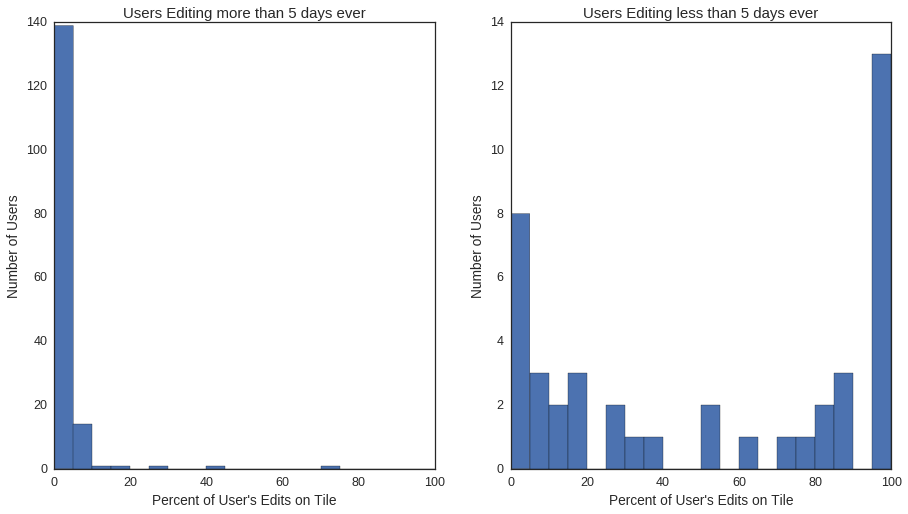

In [19]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

current_tile_df.query('total_editing_days_ever>5').plot(ax=axs[0], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[0].set_title('Users Editing more than 5 days ever')

current_tile_df.query('total_editing_days_ever<5').plot(ax=axs[1], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[1].set_title('Users Editing less than 5 days ever')

for ax in axs:
    ax.set_xlabel("Percent of User's Edits on Tile")
    ax.set_ylabel('Number of Users')

## Who's Mapping Buildings and Roads?

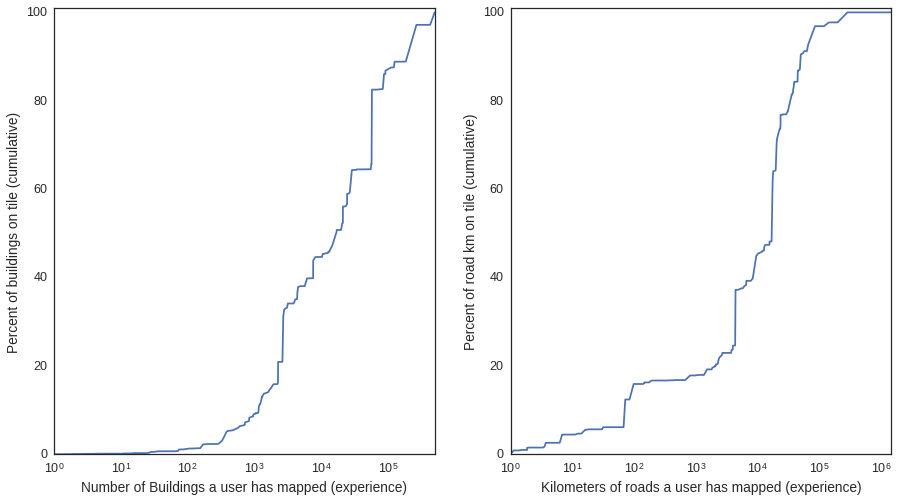

In [20]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

b_view = current_tile_df.sort_values(by='total_buildings_ever')
b_view['cumulative_percent'] = b_view.percent_tile_buildings.cumsum()

b_view.plot(ax=axs[0],x='total_buildings_ever',y='cumulative_percent', logx=True,legend=None)

axs[0].set_ylabel('Percent of buildings on tile (cumulative)')
axs[0].set_xlabel('Number of Buildings a user has mapped (experience)')


r_view = current_tile_df.sort_values(by='total_road_km_ever')
r_view['cumulative_percent'] = r_view.percent_tile_road_km.cumsum()

r_view.plot(ax=axs[1],x='total_road_km_ever',y='cumulative_percent', logx=True,legend=None)

axs[1].set_ylabel('Percent of road km on tile (cumulative)')
axs[1].set_xlabel('Kilometers of roads a user has mapped (experience)')

for ax in axs:
    ax.set_ylim(0,101)
    ax.set_xlim(1)
#     ax.set_xlabel("Percent of User's Edits on Tile")
#     ax.set_ylabel('Number of Users')

<br>
<hr>
<br>

<hr>
# Run Tile-by-Tile Comparisons
For each study tile, we have _comparable_ tiles, these are the tiles of most interest, because the difference in patterns between these tiles and our study tiles is what makes the analysis.

## 1. Get a _comparable_ tile

In [34]:
if 'compare_tiles' in study_tiles[study_tile_idx]:
    print("Comparable Tiles for {0}: ".format(study_tiles[study_tile_idx]['name']))
    for idx, compare in enumerate(study_tiles[study_tile_idx]['compare_tiles']):
        print("\t{0}, '{1}'".format(idx, compare['quad']))

Comparable Tiles for Monrovia, Liberia: 
	0, '310101233020'


In [35]:
#Which tile to compare? (from within the comparable study tiles)
idx=0

## 2. Get Users

In [36]:
pd_connections = reset(pd_connections)
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx]['compare_tiles'][idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

## 3. Build actual user distribution (may take a few minutes)
If it fails, run the above cell again (probably twice)

In [37]:
study_tiles[study_tile_idx]['compare_tiles'][idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list'])

 167/ ~ 226

In [25]:
# Check these results?
display.display(study_tiles[study_tile_idx]['compare_tiles'][idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,120201132302,2007,7749,0,0.045943,1,8,1,7749,Matze,2007,0,791.482,18,14391,44
1,120201132213,2007,7749,0,1.031600,2,123,2,7749,Matze,2007,0,791.482,18,14391,44
2,120201303123,2007,7749,0,3.203340,0,109,2,7749,Matze,2007,0,791.482,18,14391,44
3,120201303122,2007,7749,0,6.175670,0,1,1,7749,Matze,2007,0,791.482,18,14391,44
4,120201303033,2007,7749,0,1.652740,0,1,1,7749,Matze,2007,0,791.482,18,14391,44


## 4. Now process user focus for compare tiles

In [26]:
process_dictionary_of_users(study_tiles[study_tile_idx]['compare_tiles'][idx]['users'])
display.display(study_tiles[study_tile_idx]['compare_tiles'][idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list'][0]]['tiles'].head())
display.display(study_tiles[study_tile_idx]['compare_tiles'][idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list'][0]]['annual'].head())

 47/47

,buildings,road_km,edits,amenities,num_days,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
023012311301,0,0.00000,1,0,1,0.000000,0.0,0.0,0.006085
023012311303,0,0.00000,4,0,1,0.000000,0.0,0.0,0.024338
023013200223,0,6.71009,71,0,2,0.636372,0.0,0.0,0.432005
023013202001,0,15.09830,57,0,3,1.431895,0.0,0.0,0.346821
023013202003,0,1.65447,5,0,2,0.156907,0.0,0.0,0.030423


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,7749,Matze,2007,0,791.4820,18,14391,44
1,7749,Matze,2008,4,129.1220,31,1479,34
2,7749,Matze,2009,51,44.4655,87,250,32
3,7749,Matze,2010,87,7.0207,4,130,4
4,7749,Matze,2011,2,30.3767,11,78,6


## 5. Build Compare Tile Full Stats

In [27]:
compare_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx]['compare_tiles'][idx])
compare_tile_df.count().head()

buildings    47
road_km      47
edits        47
amenities    47
num_days     47
dtype: int64

# Now compare the tiles

First, basic stats: 

In [28]:
print("Users on Study Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['user_list']), len(current_tile_df)))
print("Users on Compare Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list']), len(compare_tile_df)))

Users on Study Tile: 201, 201
Users on Compare Tile: 47, 47


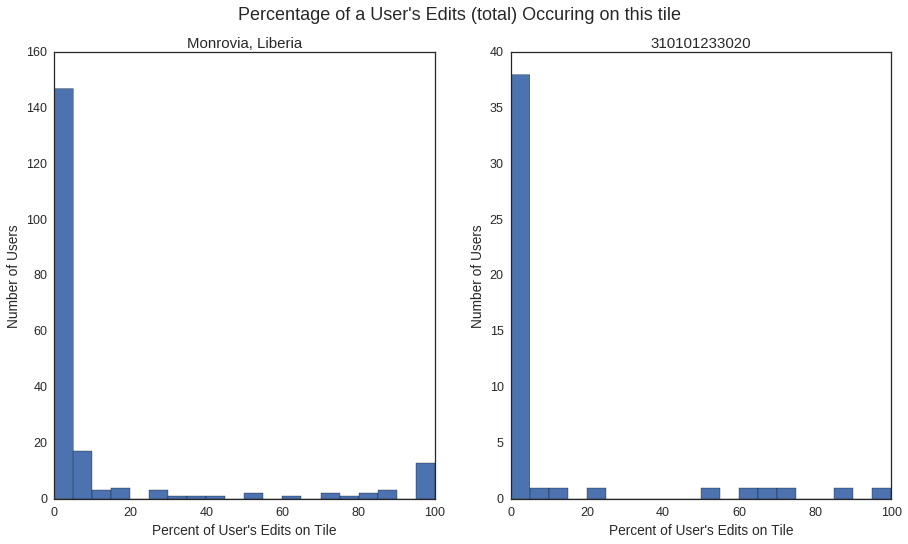

In [29]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

#Editing more than 7 days
current_tile_df.plot(ax=axs[0], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[0].set_title(study_tiles[study_tile_idx]['name'])

#Editing just 1 day
compare_tile_df.plot(ax=axs[1], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[1].set_title(study_tiles[study_tile_idx]['compare_tiles'][idx]['quad'])

for ax in axs:
    ax.set_xlabel("Percent of User's Edits on Tile")
    ax.set_ylabel('Number of Users')
plt.suptitle("Percentage of a User's Edits (total) Occuring on this tile",fontsize=18)

# Compare Buildings & Roads Across Two _Similar_ Tiles

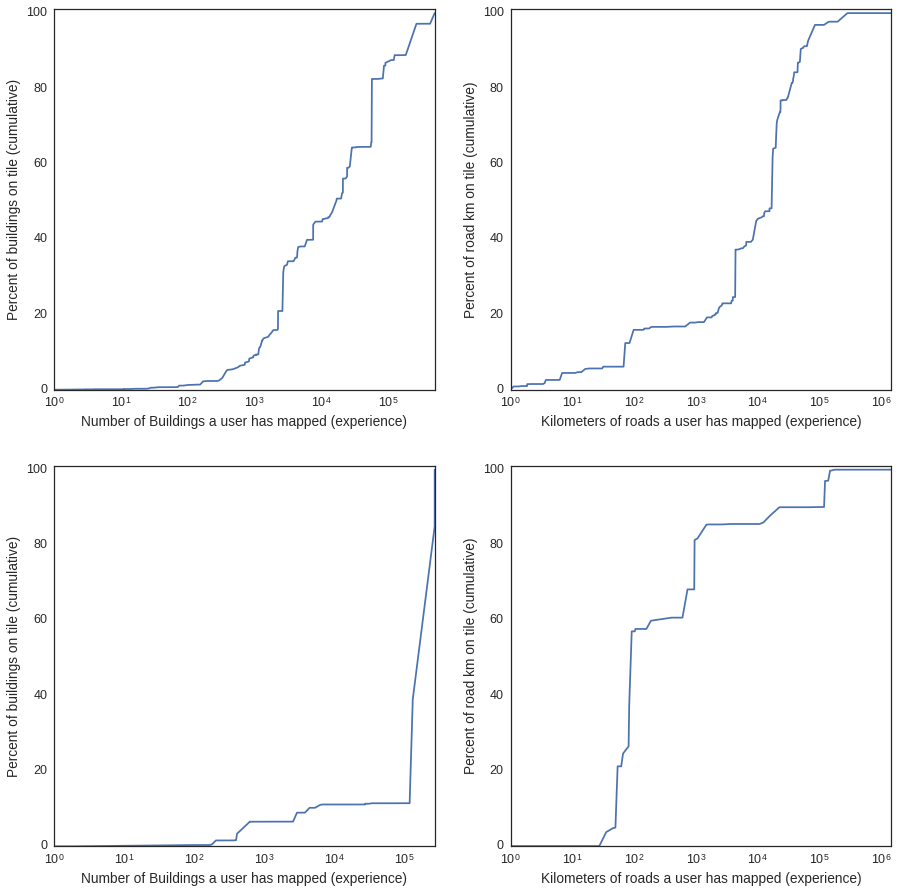

In [30]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15), facecolor='w', edgecolor='k')

for idx, tile in enumerate([current_tile_df, compare_tile_df]):
    this_axis = axs[idx]
    b_view = tile.sort_values(by='total_buildings_ever')
    b_view['cumulative_percent'] = b_view.percent_tile_buildings.cumsum()

    b_view.plot(ax=this_axis[0],x='total_buildings_ever',y='cumulative_percent', logx=True,legend=None)

    this_axis[0].set_ylabel('Percent of buildings on tile (cumulative)')
    this_axis[0].set_xlabel('Number of Buildings a user has mapped (experience)')

    r_view = tile.sort_values(by='total_road_km_ever')
    r_view['cumulative_percent'] = r_view.percent_tile_road_km.cumsum()

    r_view.plot(ax=this_axis[1],x='total_road_km_ever',y='cumulative_percent', logx=True,legend=None)

    this_axis[1].set_ylabel('Percent of road km on tile (cumulative)')
    this_axis[1].set_xlabel('Kilometers of roads a user has mapped (experience)')

    for ax in this_axis:
        ax.set_ylim(0,101)
        ax.set_xlim(1)

## Analysis

Top Row: Monrovia, Liberia.  Bottom Row: [Similar Tile](http://www.townsendjennings.com/geojson-polygons?geojson=http://epic-analytics.cs.colorado.edu:9000/jennings/iscram/Monrovia%2c%20Liberia_sim_tiles.geojson#12.54/-5.1349/120.2784)

Most of the buildings on this tile were added by users with significant experience adding buildings; most likely a single import.

In [41]:
compare_tile_df.sort_values(by="total_buildings_ever",ascending=False)

,buildings,road_km,edits,amenities,num_days,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits,uid,total_editing_days_ever,total_buildings_ever,total_road_km_ever,total_amenities_ever,total_edits_ever,percent_tile_road_km,percent_tile_buildings,percent_tile_amenities,percent_tile_edits
16,2743,9.519250,2764,0,3,0.649095,0.997883,0.000000,0.988286,617262,98,274882,1.466546e+03,19,279676,3.635432,15.115446,0.0,14.394334
17,8315,34.291000,8425,0,3,3.631023,3.025198,0.000000,3.044385,2896303,96,274858,9.443900e+02,4,276739,13.095842,45.820246,0.0,43.875638
21,5011,19.635900,5048,0,2,2.707808,3.746234,0.000000,3.727167,571194,124,133761,7.251583e+02,100,135438,7.499013,27.613380,0.0,26.288928
30,0,1.042850,2,0,1,0.008515,0.000000,0.000000,0.001173,1911765,720,120601,1.224766e+04,3260,170478,0.398268,0.000000,0.0,0.010416
19,0,0.090578,1,0,1,0.000059,0.000000,0.000000,0.000261,1829683,610,107167,1.547841e+05,253,383479,0.034592,0.000000,0.0,0.005208
1,2,0.000000,2,0,2,0.000000,0.002164,0.000000,0.001919,617220,287,92426,5.363660e+03,1611,104200,0.000000,0.011021,0.0,0.010416
27,0,5.613900,7,0,3,0.025189,0.000000,0.000000,0.004099,121295,856,76951,2.228675e+04,269,170753,2.143966,0.000000,0.0,0.036455
26,0,0.602732,3,0,3,0.000344,0.000000,0.000000,0.000802,2219338,461,60824,1.750088e+05,460,374033,0.230185,0.000000,0.0,0.015623
14,0,0.228839,1,0,1,0.000166,0.000000,0.000000,0.000332,2512300,339,59534,1.374727e+05,1501,300900,0.087394,0.000000,0.0,0.005208
36,0,0.000000,1,0,1,0.000000,0.000000,0.000000,0.000186,77114,1439,55744,6.488810e+04,2348,538022,0.000000,0.000000,0.0,0.005208
